In [1]:
'''
#Gigacow-tools# - data collection for fast/slow learner.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#access data from local directory
dataDir = Path.cwd().parent.parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

5613    11903
6197    11250
4478    11054
3757    10907
2423    10864
3147    10083
4504    10016
5147     9758
3121     9518
5046     9390
Name: Gigacow_Cow_Id, dtype: int64


In [2]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

# select records that contains lactation period 1
milking_select1 = milking_total.loc[milking_total['LactationNumber'] == 1]
milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
# drop the anomaly data point
milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
# select sufficient data points on lactation 1
selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
selected1 = selected1.loc[(selected1.values > 80) & (selected1.values < 365)]
cow_list = selected1.index.to_list()
print(len(cow_list), cow_list)

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\531552049.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\531552049.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\531552049.py:11: SettingWithCopyWarning: 
A value is trying to 

116 [6351, 2694, 5442, 3468, 919, 855, 2792, 385, 1551, 5948, 560, 2805, 5848, 4765, 2712, 1336, 90, 961, 4295, 5873, 5844, 1244, 3075, 4109, 3890, 6360, 3603, 6127, 2956, 3638, 3563, 4200, 2031, 4988, 544, 2090, 6018, 4704, 5555, 2135, 622, 6316, 5076, 4537, 3744, 2251, 4899, 4939, 4195, 2724, 951, 5846, 2460, 3446, 3487, 3979, 2560, 1744, 1555, 5767, 3657, 5301, 151, 3705, 5965, 182, 5046, 702, 4525, 5322, 2569, 4311, 6086, 4038, 3762, 6241, 2047, 708, 3707, 6380, 3613, 4341, 2844, 2979, 4176, 1796, 2278, 4990, 5616, 769, 1247, 943, 5092, 5852, 3447, 5147, 2702, 1181, 2423, 478, 5160, 1905, 2039, 6472, 985, 926, 2510, 1738, 74, 1985, 5235, 5088, 5465, 1103, 3718, 2374]


In [4]:

# select records that contains lactation period 2
milking_select2 = milking_total.loc[milking_total['LactationNumber'] == 2]
milking_select2.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
# drop the anomaly data point
milking_select2 = milking_select2.loc[milking_select2.DaysInMilk < 400]
# select sufficient data points on lactation 2
selected2 = milking_select2.Gigacow_Cow_Id.value_counts(ascending=True)
selected2 = selected2.loc[(selected2.values > 80) & (selected2.values < 365)]
cow_list2 = selected2.index.to_list()
print(len(cow_list2), cow_list2)
cow_list_12 = list(set(cow_list) & set(cow_list2))
print(len(cow_list_12), cow_list_12)


103 [2240, 1461, 4637, 6360, 4632, 2278, 5160, 3707, 5555, 5844, 3603, 3884, 6405, 4008, 3638, 4544, 2031, 2354, 4848, 315, 3532, 6487, 5948, 1985, 1287, 3636, 2952, 1738, 574, 17, 1606, 4425, 5088, 3857, 5221, 5904, 5560, 3641, 3147, 5092, 1687, 4275, 1420, 910, 433, 6352, 4709, 562, 5848, 4906, 1103, 1624, 5183, 3792, 4316, 2382, 74, 3531, 80, 4257, 1348, 6351, 3674, 3121, 5211, 2000, 4074, 2946, 3127, 874, 636, 478, 5147, 6485, 1706, 1846, 3718, 2195, 5614, 5477, 560, 919, 926, 2712, 4220, 697, 129, 5470, 920, 849, 1181, 2237, 182, 6380, 1555, 5046, 2569, 6177, 90, 5613, 2423, 4825, 5442]
8 [5088, 1985, 3718, 5160, 1738, 74, 1103, 926]


C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_32004\3194488267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_select2.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)


In [3]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

In [20]:
# select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id, lacNum):
    '''
    func: collect features from for a single cow
    args: 
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: gigacow_id of the cow
        lacNum: lactation period number
    return: A dataframe contains all features for a single cow on specfic lactation period
    '''

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    # extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge.dropna(inplace=True)

    # integrate multiple milking events for a single DIM
    single_cow_merge = single_cow_merge.loc[single_cow_merge.LactationNumber == lacNum]
    single_cow_merge.index = range(1,len(single_cow_merge)+1) 
    single_cow_merge.drop(['MilkingEventDateTime', 'Pre_MilkingEventDateTime', 'Traffic_Id', 'MilkingInterval_totalSeconds', 'RoundedSecondsTimeInArea', 'PreviousArea', 'GroupName', 'LactationInfoDate', 'TrafficDeviceName'], axis=1, inplace=True)

    comb_cows = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).sum(['MilkProduction', 'timeDelta_Seconds'])
    single_cow_merge_size = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).size()
    comb_cows = pd.concat([comb_cows, single_cow_merge_size['size']], axis=1, ignore_index=False)
    comb_cows.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    comb_cows.index = range(1, len(comb_cows)+1)

    return comb_cows

<Figure size 432x288 with 0 Axes>

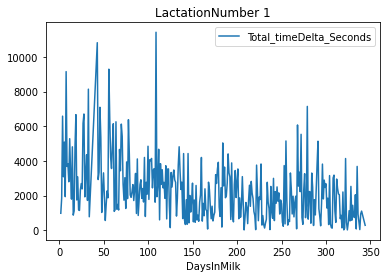

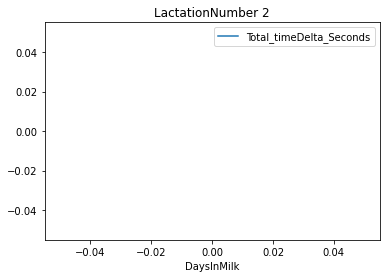

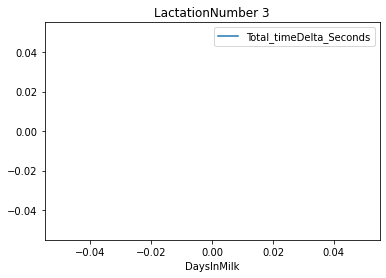

In [106]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 3718, 1)
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='line', title='LactationNumber 3')
plt.show()


<Figure size 432x288 with 0 Axes>

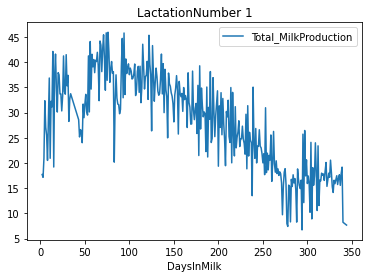

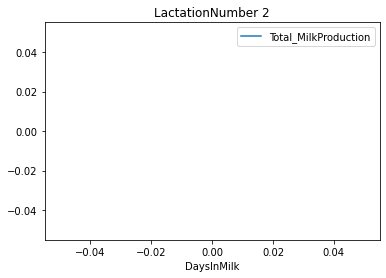

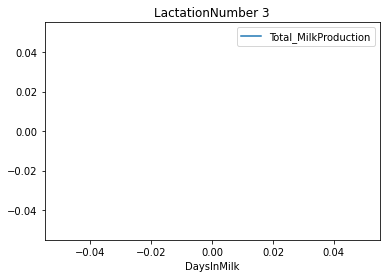

In [108]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 3718, 1)
plt.figure()
single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 1')
single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 2')
single_cow_merge.loc[single_cow_merge.LactationNumber == 3].plot(x="DaysInMilk", y="Total_MilkProduction", kind='line', title='LactationNumber 3')
plt.show()

In [21]:
# plot the relations between timeDielta and Lactation/DIM(DaysInMilk)
single_cow_merge = data_collector(traffic, gigacow, lactation, 3718, 1)
single_cow_merge

C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\1559297404.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\1559297404.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
C:\Users\Savior_Hn\AppData\Local\Temp\ipykernel_20244\1559297404.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

765178.0


,FarmName_Pseudo,Gigacow_Cow_Id,MilkingDate,LactationNumber,DaysInMilk,BreedName,Age,Total_MilkProduction,Total_timeDelta_Seconds,milking_times
1,a624fb9a,3718,2020-10-10,1.0,2.0,1,1.99,17.70,981.0,2
2,a624fb9a,3718,2020-10-11,1.0,3.0,1,1.99,17.14,1856.0,2
3,a624fb9a,3718,2020-10-12,1.0,4.0,1,1.99,20.93,6579.0,3
4,a624fb9a,3718,2020-10-13,1.0,5.0,1,1.99,32.34,3087.0,4
5,a624fb9a,3718,2020-10-14,1.0,6.0,1,2.00,27.06,5085.0,3
...,...,...,...,...,...,...,...,...,...,...
328,a624fb9a,3718,2021-09-10,1.0,337.0,1,2.90,15.55,502.0,2
329,a624fb9a,3718,2021-09-11,1.0,338.0,1,2.91,17.91,41.0,2
330,a624fb9a,3718,2021-09-12,1.0,339.0,1,2.91,19.17,946.0,2
331,a624fb9a,3718,2021-09-13,1.0,340.0,1,2.91,8.23,1107.0,1


In [22]:
timeCost = single_cow_merge.Total_timeDelta_Seconds.sum()
totalEvents = single_cow_merge.milking_times.sum()
mean_time = timeCost/totalEvents
mean_time

829.011917659805

In [19]:
single_cow_merge.milking_times.sum()
timeCost

765178.0

In [29]:
pd.options.mode.chained_assignment = None

# 53 [1103, 1624, 5183, 3792, 4316, 2382, 74, 3531, 80, 4257, 1348, 6351, 3674, 3121, 5211, 2000, 4074, 2946, 3127, 874, 636, 478, 5147, 6485, 1706, 1846, 3718, 2195, 5614, 5477, 560, 919, 926, 2712, 4220, 697, 129, 5470, 920, 849, 1181, 2237, 182, 6380, 1555, 5046, 2569, 6177, 90, 5613, 2423, 4825, 5442]
# 13 [478, 3718, 2569, 74, 6380, 1103, 1555, 182, 5046, 5147, 1181, 926, 2423]

#cow_list_12 = [3718, 2569, 1555, 3603, 919, 2712, 5147, 1181, 926, 5160, 560, 5555, 3638, 182, 5046, 5948, 1985, 5442, 74, 1738, 1103, 6351, 5844, 6360, 5848, 90, 478, 5088, 5092, 2278, 6380, 2031, 2423, 3707]

mean_totalTimeCost = 0
Path(dataDir/'learner_targetCows').mkdir(parents=True, exist_ok=True)
lactationNum = 1

for i, cow_id in enumerate(cow_list_12):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, lactationNum)
    mean_totalTimeCost += single_cow_merge.timeDelta_Seconds.mean()
    print(str(cow_id) + "\n" + str(single_cow_merge.timeDelta_Seconds.mean()))
    print(single_cow_merge.FarmName_Pseudo.unique())
    print(single_cow_merge.timeDelta_Seconds.describe())
    #if(single_cow_merge.timeDelta_Seconds.mean() < 900):
    #    print("good")
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'learner_targetCows/cow_' + str(i) + '.csv'
    
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list_12))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list_12))

3718
827.3369330453563
['a624fb9a']
count      926.000000
mean       827.336933
std       1095.307166
min          5.000000
25%         75.250000
50%        462.000000
75%       1069.250000
max      10943.000000
Name: timeDelta_Seconds, dtype: float64
2569
322.80102040816325
['a624fb9a']
count     784.000000
mean      322.801020
std       420.924669
min         3.000000
25%        29.500000
50%       211.000000
75%       403.250000
max      3621.000000
Name: timeDelta_Seconds, dtype: float64
1555
799.4668989547039
['a624fb9a']
count     574.000000
mean      799.466899
std      1113.289313
min         4.000000
25%       128.750000
50%       409.000000
75%       905.000000
max      9382.000000
Name: timeDelta_Seconds, dtype: float64
3603
1872.1141732283465
['f454e660']
count      254.000000
mean      1872.114173
std       2113.405421
min          5.000000
25%        378.250000
50%       1023.000000
75%       2776.750000
max      15061.000000
Name: timeDelta_Seconds, dtype: float64
919
14

In [116]:
pd.options.mode.chained_assignment = None

mean_totalTimeCost = 0
Path(dataDir/'learner_targetCows').mkdir(parents=True, exist_ok=True)
lactationNum = 1

for i, cow_id in enumerate(cow_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, lactationNum)
    mean_totalTimeCost += single_cow_merge.Total_timeDelta_Seconds.mean()
    print(single_cow_merge.Total_timeDelta_Seconds.mean())
    #if(single_cow_merge.Total_timeDelta_Seconds.mean() < 900):
    #    print("good")
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'learner_targetCows/cow_' + str(i) + '.csv'
    
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list))

1155.125
11179.530120481928
2933.1686746987953
14012.95
3745.8536585365855
7408.771929824561
4540.876404494382
5604.516853932584
1319.2222222222222
2417.8375
2568.0947368421052
5665.336842105263
4101.148148148148
4810.634615384615
1867.451923076923
1458.135593220339
2100.443181818182
6382.957142857143
10546.607476635514
9849.10891089109
2112.185185185185
2704.616666666667
8033.556451612903
10870.20987654321
4469.538461538462
5231.8133333333335
3690.983870967742
3922.1136363636365
1622.0601265822784
2607.404761904762
17367.78417266187
3195.2904191616767
1980.023622047244
10148.111111111111
11030.781690140846
3332.112582781457
7679.872483221477
3132.315789473684
2726.9727891156463
7080.789808917198
2777.0
5135.067796610169
5271.361445783133
9873.270967741935
8700.24844720497
5243.168604651163
2743.432926829268
3384.1802325581393
3400.502923976608
6708.6933797909405
3578.0919540229884
3545.9385474860337
4514.303797468355
4317.823204419889
4184.130434782609
7868.2990654205605
2532.31937172